# Demo workflows

Below are demonstrated the use of this library as a Python package and from the command line interface. Note that one step demonstrated below is to save datasets you need to run the local examples.

In [1]:
import xarray as xr
import ocean_data_gateway as odg
import cf_xarray
import pandas as pd
import extract_model as em
import ocean_model_skill_assessor as omsa
import numpy as np
from IPython import display
from glob import glob

## Definitions

These dictionaries are not required for every type of run, but are required for identifying variables between datasets and models, and for running QC. They can be complicated if desired, but do not have to be. Once they are written they do not need to be modified much. More information about these dictionaries is available in the [`ocean_data_gateway` docs](https://ocean-data-gateway.readthedocs.io/en/latest/details.html#Configure-custom-criteria-and-variable-definitions).

In [2]:
criteria = {
    "salt": {
        "name": "sea_water_practical_salinity$",
    },
}

var_def = {
    "salt": {"units": "psu", "fail_span": [-10, 60], "suspect_span": [-1, 45]},
}


A more complicated example of `criteria` is shown here, as it can be brought it from a nonlocal source:

In [3]:
url = 'https://gist.githubusercontent.com/kthyng/c3cc27de6b4449e1776ce79215d5e732/raw/af448937e4896535e36ef6522df8460e8f928cd6/my_custom_criteria.py'
criteria = odg.return_response(url)
criteria

{'ssh': {'standard_name': 'sea_surface_height$|sea_surface_elevation|sea_surface_height_above_sea_level$',
  'name': '(?i)sea_surface_elevation(?!.*?_qc)|(?i)sea_surface_height_above_sea_level_geoid_mllw$|(?i)zeta$|(?i)Sea Surface Height(?!.*?_qc)|(?i)Water Surface above Datum(?!.*?_qc)'},
 'temp': {'name': '(?i)temp$|(?i)temperature$|(?i)tem$|(?i)s.sea_water_temperature$|(?i)temperature(?!.*(skin|ground|air|_qc))'},
 'salt': {'standard_name': 'sea_water_salinity$|sea_water_practical_salinity$',
  'name': '(?i)salinity(?!.*(soil|_qc))|(?i)sea_water_salinity$|(?i)sea_water_practical_salinity$|(?i)salinity$|(?i)salt$|(?i)sal$|(?i)s.sea_water_practical_salinity$'},
 'u': {'standard_name': 'eastward_sea_water_velocity$|sea_water_x_velocity|surface_eastward_sea_water_velocity',
  'name': '(?i)eastward_sea_water_velocity(?!.*?_qc)|(?i)sea_water_x_velocity(?!.*?_qc)|(?i)uo(?!.*?_qc)'},
 'v': {'standard_name': 'northward_sea_water_velocity$|sea_water_y_velocity|surface_northward_sea_water_velo

In [4]:
kw = {
    "min_lon": -153,
    "max_lon": -145,
    "min_lat": 57,
    "max_lat": 65,
    "min_time": '2022-4-15',
    "max_time": '2022-5-4',
}

In [5]:
# setup Data search object
data = odg.Gateway(kw=kw, approach='region')

In [ ]:
odg.Gateway?

In [6]:
len(data.dataset_ids)

554

In [ ]:
# # valid_ids = [29, 34, 41, 52, 212, 357, 381]
# # valid_dss = ['cdmo_nerrs_3b00077a', 'noaa_nos_co_ops_9454050', 'nerrs_kacsswq', 'nerrs_kach3wq', 'nerrs_kacsdwq', 'nerrs_kachdwq', 'cdmo_nerrs_3b040240']
# valid_ids = []
# valid_dss = []
# for k in range(544, len(data.dataset_ids)): # parei em 358
#     if data[data.dataset_ids[k]]: 
#         if ('sea_water_salinity' in data[data.dataset_ids[k]].variables) | ('sea_water_practical_salinity' in data[data.dataset_ids[k]].variables):
#             print(k, '  ', data.dataset_ids[k])
#             valid_ids.append(k)
#             valid_dss.append(data.dataset_ids[k])

In [7]:
valid_dss = ['cdmo_nerrs_3b00077a',
 'noaa_nos_co_ops_9454050',
 'nerrs_kacsswq',
 'nerrs_kach3wq',
 'nerrs_kacsdwq',
 'nerrs_kachdwq',
 'cdmo_nerrs_3b040240']

'net_cvinternet_naked'

In [9]:
# plotting just stations with salinity 
import matplotlib.pyplot as plt

plot_lat = []
plot_lon = []
plot_text = []
for valid_ds in valid_dss:
    plot_lat.append(data[valid_ds].latitude)
    plot_lon.append(data[valid_ds].longitude)
    # plot_text.append(str(k))

In [10]:
# getting info for model output access
# https://ncss.hycom.org/thredds/ncss/grid/GLBy0.08/expt_93.0/ts3z/dataset.html
# hindcast, w/ temp and salt, only surface, entre (-153, -145)w, (65, 57)n, para 15/apr - 04/mai/2022
# surface only

from urllib import request

time_start = '2022-04-15T12'
time_end = '2022-05-04T09'

model_url = f"https://ncss.hycom.org/thredds/ncss/GLBy0.08/expt_93.0/ts3z?var=salinity&var=water_temp&north=65&west=-153&east=-145&south=57&disableProjSubset=on&horizStride=1&time_start={time_start}%3A00%3A00Z&time_end={time_end}%3A00%3A00Z&timeStride=1&vertCoord=1&accept=netcdf"

response = request.urlretrieve(model_url, 'hycomglb93.0_model_output.nc')

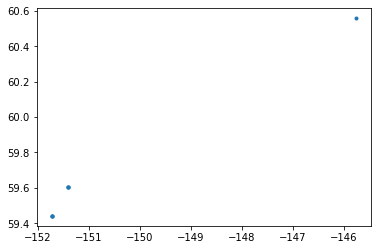

In [11]:
# plotting all stations
plt.plot(plot_lon,plot_lat,'.')
plt.show()

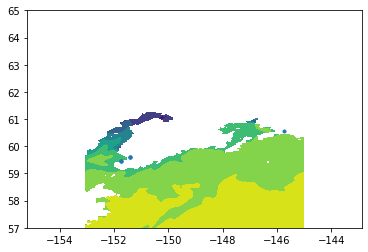

In [13]:
# plotting all stations
import netCDF4 as nc
aux = nc.Dataset('hycomglb93.0_model_output.nc')
salinity = aux.variables['salinity'][:]
lat = aux.variables['lat'][:]
lon = aux.variables['lon'][:]-360

import matplotlib.pyplot as plt
import numpy as np
plt.contourf(lon,lat,np.squeeze(salinity[0,0,:,:]))
plt.plot(plot_lon,plot_lat,'.')
plt.axis('equal')
# for k in range(len(plot_lon)):
#     plt.plot(plot_lon[k],plot_lat[k],plot_text[k])
plt.show()

In [14]:
# best datasets
dataset_ids = ['noaa_nos_co_ops_9454050', 'nerrs_kacsdwq']

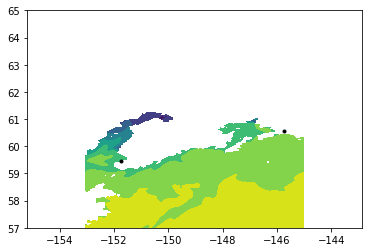

In [15]:
# plotting the model with the chosen stations overlayed. Quick look.
plt.contourf(lon,lat,np.squeeze(salinity[0,0,:,:]))
plt.plot(data[dataset_ids[0]].longitude.values,data[dataset_ids[0]].latitude.values,'.k')
plt.plot(data[dataset_ids[1]].longitude.values,data[dataset_ids[1]].latitude.values,'.k')
plt.axis('equal')
plt.show()

In [36]:
# TRYING WITH A DIFFERENT MODEL - MAYBE THE ISSUE IS HOW TO REACH THE MODEL RESULTS. 
# NOW TRYING TO DO IT IN A WAY THAT'S MORE SIMILAR TO THE ORIGINAL ONE, but other time period
# https://portal.aoos.org/#module-metadata/c06c2f24-0f40-11e3-a373-00219bfe5678/3c75747e-421f-4594-abfb-bda77039f215
# Aug 18, 2015 20:00 (EDT) - Oct 23, 2018 20:00 (EDT)

from urllib import request
model_url = 'https://thredds.cencoos.org/thredds/dodsC/HYCOM.nc'

response = request.urlretrieve(model_url, 'hycomwestcoast_model_output.nc')
# doesn't work either. HTTPError 400

HTTPError: HTTP Error 400: 

## Python library

This package can be used as a Python package or from the command line. Here we demonstrate its use as a Python package.

### Nonlocal reader: stations

This demonstrates the case in which your data files for comparing with model output are not available locally, but you know their names and where to find them (in this case, at the IOOS ERDDAP server). More information about these inputs is available in the [API docs](https://ocean-model-skill-assessor.readthedocs.io/en/latest/api.html).

In [35]:
search = omsa.run(loc_model='hycomglb93.0_model_output.nc',
                  approach='stations',
                  criteria=criteria,
                  var_def=var_def,
                  xarray_kwargs={'chunks': {'time': 1, 'depth': 1}},
                  time_range=['2022-4-15','2022-5-4'], 
                  variables=['salt'],
                  readers=[odg.erddap],
                  erddap={
                      'known_server': 'ioos'
                  },
                  stations = dataset_ids,
                  figname_map='nonlocal_library.png',
                  figname_data_prefix='nonlocal_library_',
                  parallel=False
)

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy', 'zarr']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

#### Save local data files

Here we save the data files to use for the local examples.

In [32]:
# dataset_ids = ['noaa_nos_co_ops_9454050', 'nerrs_kacsdwq']
search['nerrs_kacsdwq'].squeeze().to_dataframe().to_csv('nerrs_kacsdwq.csv')
search['noaa_nos_co_ops_9454050'].squeeze().to_dataframe().to_csv('noaa_nos_co_ops_9454050.csv')
# both csv for now; there's problem with the conflicting missing value and fill value for the netcdf

### Nonlocal reader: region

This demonstrates the case in which your data files for comparing with model output are not available locally, and you want to perform a search in time and space. By default this would search in the spatial bounding box of the model output, but here we instead input a smaller bounding box so as to limit the number of datasets found and used. For several of the datasets, the model output isn't available (must be determined to be on land). 

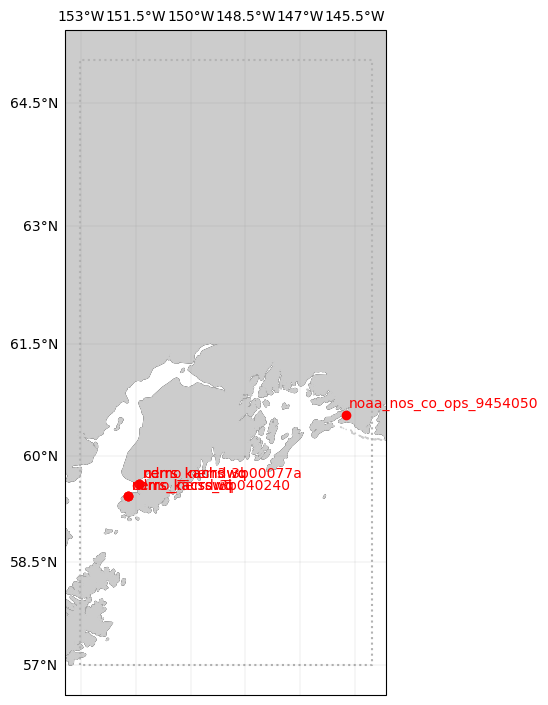

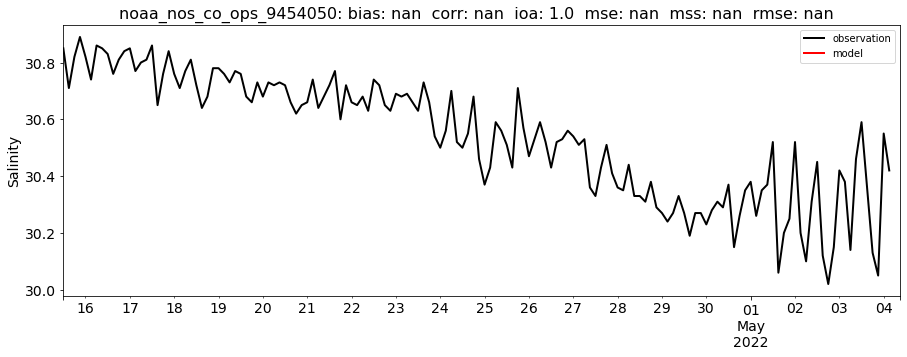

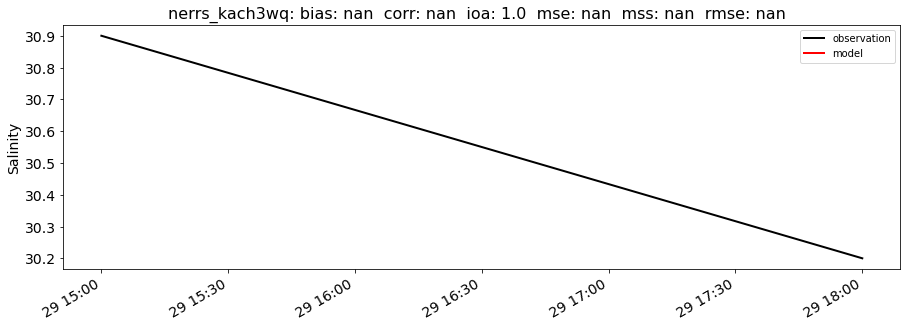

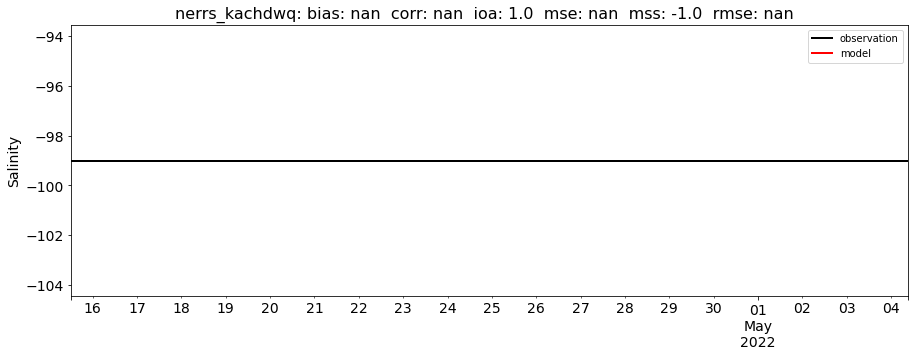

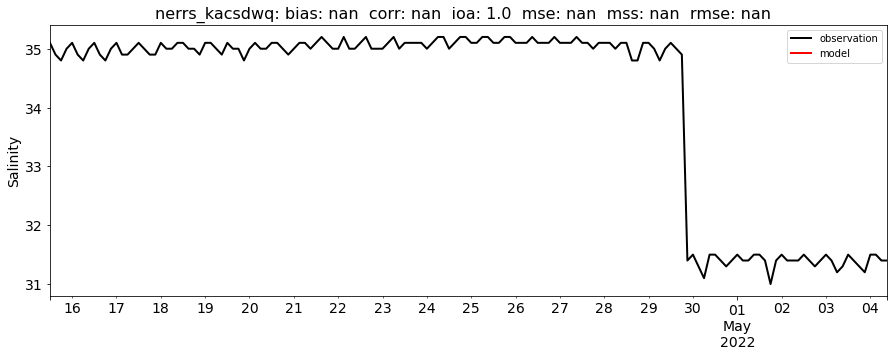

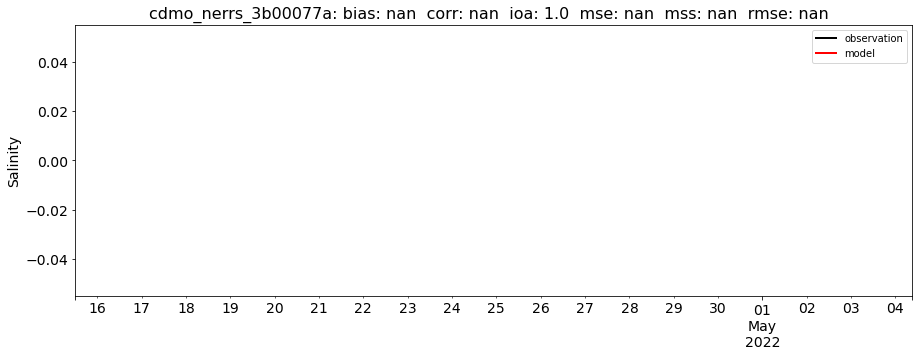

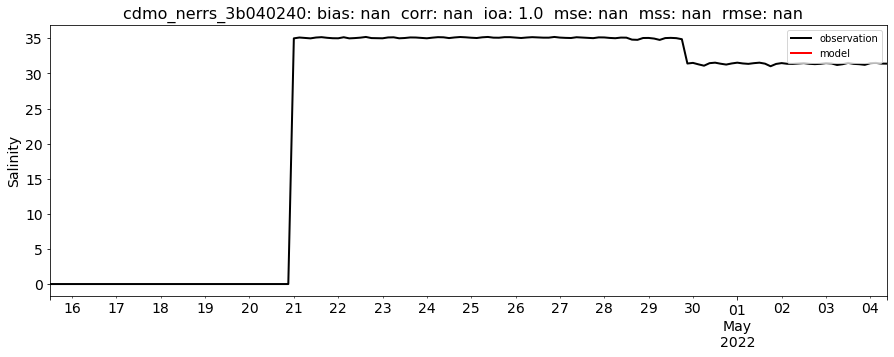

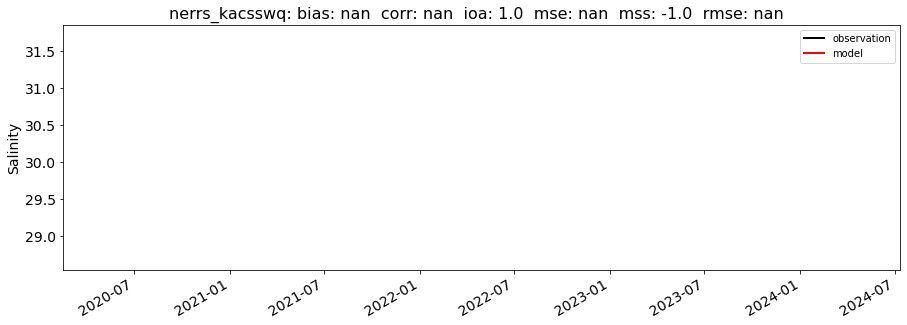

In [30]:
omsa.set_criteria(criteria)

bbox = [-153, 57, -145, 65]
search = omsa.run(
                  loc_model='hycomglb93.0_model_output.nc',
                  approach='region',
                  bbox=bbox,
                  criteria=criteria,
                  var_def=var_def,
                  xarray_kwargs={'chunks': {'time': 1, 'depth': 1}},
                  time_range=['2022-4-15','2022-5-4'], 
                  variables=['salt'],
                  readers=[odg.erddap],
                  erddap={
                      'known_server': 'ioos'
                  },
                  figname_map='nonlocal_library_region.png',
                  figname_data_prefix='nonlocal_library_region_'
)

### Local reader

This demonstrates the case in which your data files for comparing with model output are available locally.

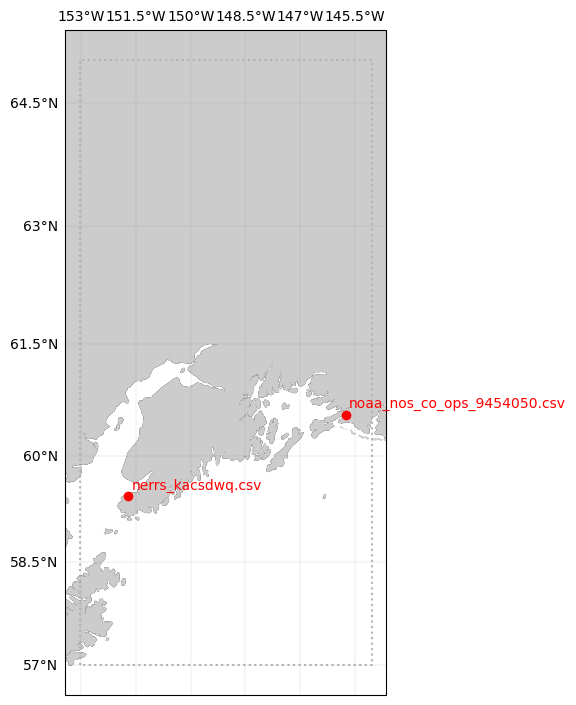

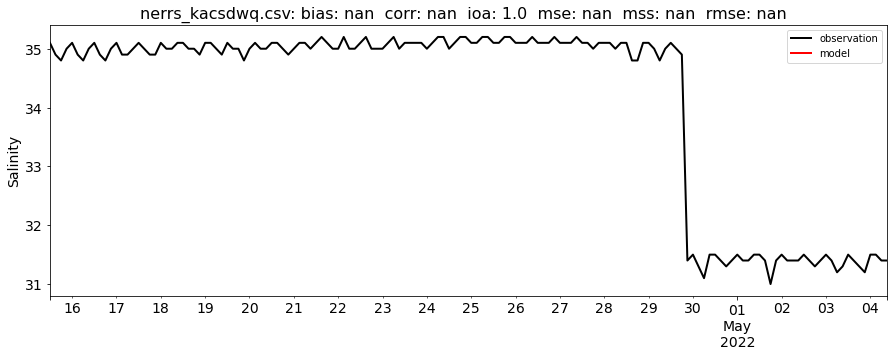

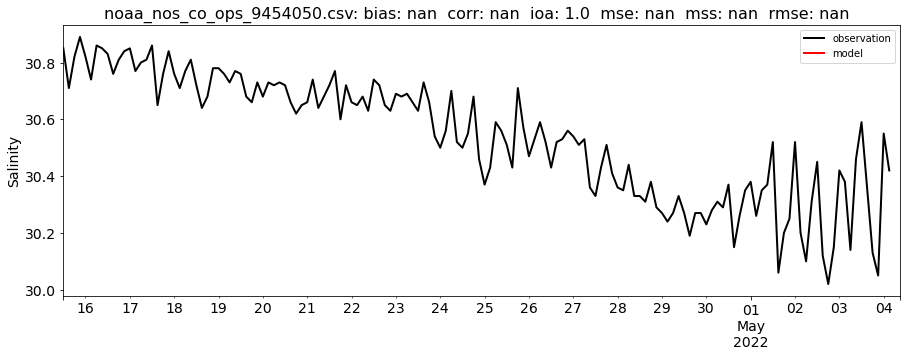

In [34]:
omsa.set_criteria(criteria)

filenames = [
             'nerrs_kacsdwq.csv',
             'noaa_nos_co_ops_9454050.csv',
            ]

skip_units = True

search = omsa.run(
                  loc_model='hycomglb93.0_model_output.nc',
                  approach='region',
                  criteria=criteria,
                  var_def=var_def,
                  skip_units=skip_units,
                  xarray_kwargs={'chunks': {'time': 1, 'depth': 1}},
                  time_range=['2022-4-15','2022-5-4'],  
                  variables=['salt'],
                  readers=[odg.local],
                  local={'filenames': filenames},
                  figname_map='local_library.png',
                  figname_data_prefix='local_library_'
)

## Command line interface

Here we demonstrate the use of the command line interface mode of the package. The config yaml file must be modified for the necessary inputs. These are the same examples as above, but accomplished via the command line interface instead of the Python package.

### Local reader

In [ ]:
config_file = 'config_local.yaml'

In [ ]:
# %load config_local.yaml
---
approach: "stations"
loc_model: "https://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc"
axds:
bbox:
criteria:
  salt:
    name:
      "sea_water_practical_salinity$"
erddap:
figname_map: "local_cli.png"
figname_data_prefix: "local_cli_"
local:
  filenames:
    - "edu_humboldt_tdp.csv"
    - "bodega-bay-bml_wts.nc"
only_search: false
only_searchplot: false
parallel: true
readers:
  - "local"
run_qc: false
skip_units: true
stations:
time_range:
  - "2021-9-1"
  - "2021-9-8"
var_def:
  salt:
    units: "psu"
    fail_span:
      - -10
      - 60
    suspect_span:
      - -1
      - 45
variables:
  - "salt"
xarray_kwargs:
  chunks:
    time:
      1
    depth:
      1


In [ ]:
!python ../ocean_model_skill_assessor/CLI.py $config_file

In [ ]:
display.Image("local_cli.png")

In [ ]:
display.Image('local_cli_edu_humboldt_tdp.csv_salt.png')

In [ ]:
display.Image('local_cli_bodega-bay-bml_wts.nc_salt.png')

### Nonlocal workflow: stations

In [ ]:
config_file = 'config_nonlocal.yaml'

In [ ]:
# %load config_nonlocal.yaml
---
approach: "stations"
loc_model: "https://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc"
axds:
bbox:
criteria:
  salt:
    name:
      "sea_water_practical_salinity$"
erddap:
  known_server:
    "ioos"
figname_map: "nonlocal_cli.png"
figname_data_prefix: "nonlocal_cli_"
local:
only_search: false
only_searchplot: false
parallel: true
readers:
  - "erddap"
run_qc: false
skip_units: true
stations:
  - "edu_humboldt_tdp"
  - "bodega-bay-bml_wts"
time_range:
  - "2021-9-1"
  - "2021-9-8"
var_def:
  salt:
    units: "psu"
    fail_span:
      - -10
      - 60
    suspect_span:
      - -1
      - 45
variables:
  - "salt"
xarray_kwargs:
  chunks:
    time:
      1
    depth:
      1


In [ ]:
whos

In [ ]:
!python ../ocean_model_skill_assessor/CLI.py $config_file

In [ ]:
display.Image("nonlocal_cli.png")

In [ ]:
display.Image('nonlocal_cli_edu_humboldt_tdp_salt.png')

In [ ]:
display.Image('nonlocal_cli_bodega-bay-bml_wts_salt.png')

### Nonlocal reader: region

In [ ]:
config_file = 'config_nonlocal_region.yaml'

In [ ]:
# %load config_nonlocal_region.yaml
---
approach: "region"
loc_model: "https://thredds.cencoos.org/thredds/dodsC/CENCOOS_CA_ROMS_FCST.nc"
axds:
bbox:
  - -124.5
  - 40
  - -123.5
  - 42
criteria:
  salt:
    name:
      "sea_water_practical_salinity$"
erddap:
  known_server:
    "ioos"
figname_map: "nonlocal_cli_region.png"
figname_data_prefix: "nonlocal_cli__region"
local:
only_search: false
only_searchplot: false
parallel: true
readers:
  - "erddap"
run_qc: false
skip_units: true
stations:
time_range:
  - "2021-9-1"
  - "2021-9-8"
var_def:
  salt:
    units: "psu"
    fail_span:
      - -10
      - 60
    suspect_span:
      - -1
      - 45
variables:
  - "salt"
xarray_kwargs:
  chunks:
    time:
      1
    depth:
      1

In [ ]:
!python ../ocean_model_skill_assessor/CLI.py $config_file

In [ ]:
display.Image("nonlocal_cli_region.png")

In [ ]:
display.Image('nonlocal_cli__regionexploratorium-pco2-buoy_salt.png')

In [ ]:
display.Image('nonlocal_cli__regionedu_calpoly_marine_morro_salt.png')

In [ ]:
display.Image('nonlocal_cli__regionsccoos_ucsd_salt.png')